In [1]:
import struct
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as f
from pyspark.sql.functions import when, col, lag, lit, atan
import matplotlib.pyplot as plt
from math import log
import numpy as np
from scipy.optimize import curve_fit
from IPython.display import display, Math, Markdown, Latex
from itertools import product
import itertools
import pyspark
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, FloatType

# Setting

In [2]:
spark = SparkSession.builder \
            .master("spark://10.67.22.4:7077") \
            .appName("Project") \
            .config('spark.jars.packages', 'org.apache.hadoop:hadoop-common:3.2.0')\
            .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.2.0')\
            .config('spark.jars.packages', 'com.amazonaws:aws-java-sdk:1.11.375')\
            .config("spark.executor.cores", 4)\
            .config("spark.executor.memory", "3g")\
            .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
            .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
            .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
            .config('spark.hadoop.fs.s3a.access.key', '2186eedc366545058b0896dadf79d288')\
            .config('spark.hadoop.fs.s3a.secret.key', 'de147ce2e90741cdb9bae8f53ee5466e')\
            .config('spark.hadoop.fs.s3a.endpoint', 'https://cloud-areapd.pd.infn.it:5210')\
            .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
            .config("spark.hadoop.fs.s3a.metadatastore.impl", "org.apache.hadoop.fs.s3a.s3guard.NullMetadataStore") \
            .config("spark.hadoop.fs.s3a.path.style.access", "true") \
            .config("spark.hadoop.fs.s3a.connection.ssl.enabled","false") \
            .config("com.amazonaws.sdk.disableCertChecking","true") \
            .getOrCreate()

:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.amazonaws#aws-java-sdk added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0a8eb2e6-bd8d-4cef-9c53-f786b6288c96;1.0
	confs: [default]
	found com.amazonaws#aws-java-sdk;1.11.375 in central
	found com.amazonaws#aws-java-sdk-dlm;1.11.375 in central
	found com.amazonaws#aws-java-sdk-core;1.11.375 in central
	found commons-logging#commons-logging;1.1.3 in central
	found org.apache.httpcomponents#httpclient;4.5.5 in central
	found org.apache.httpcomponents#httpcore;4.4.9 in central
	found commons-codec#commons-codec;1.10 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found com.fasterxml.jackson.core#jackson-databind;2.6.7.1 in central
	found com.fasterxml.jackson.core#jackson-annotations;2.6.0 in central
	found com.fasterxml.jackson.core#jackson-core;2.6.7 in central
	found com.fasterxml.jackson.dataformat#jackson-dataformat-cbor;2.6.7 in

	found com.amazonaws#aws-java-sdk-dms;1.11.375 in central
	found com.amazonaws#aws-java-sdk-marketplacemeteringservice;1.11.375 in central
	found com.amazonaws#aws-java-sdk-cognitoidp;1.11.375 in central
	found com.amazonaws#aws-java-sdk-discovery;1.11.375 in central
	found com.amazonaws#aws-java-sdk-applicationautoscaling;1.11.375 in central
	found com.amazonaws#aws-java-sdk-snowball;1.11.375 in central
	found com.amazonaws#aws-java-sdk-rekognition;1.11.375 in central
	found com.amazonaws#aws-java-sdk-polly;1.11.375 in central
	found com.amazonaws#aws-java-sdk-lightsail;1.11.375 in central
	found com.amazonaws#aws-java-sdk-stepfunctions;1.11.375 in central
	found com.amazonaws#aws-java-sdk-health;1.11.375 in central
	found com.amazonaws#aws-java-sdk-costandusagereport;1.11.375 in central
	found com.amazonaws#aws-java-sdk-codebuild;1.11.375 in central
	found com.amazonaws#aws-java-sdk-appstream;1.11.375 in central
	found com.amazonaws#aws-java-sdk-shield;1.11.375 in central
	found com.

22/07/13 15:01:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
spark

In [4]:
sc = spark.sparkContext
sc

<SparkContext master=spark://10.67.22.4:7077 appName=Project>

# Preprocessing data

### Load data

In [5]:
raw = spark.read.format("binaryFile").load('s3a://mapd-minidt-batch/data_*.dat')
raw = raw.select("content").rdd.flatMap(lambda el: el)

22/07/13 15:01:37 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


### Unpack data

In [6]:
def unpack(file_content):
    ppd = []
    word_counter=0
    word_size = 8                                             # size of the word in bytes
    for i in range(0, len(file_content), word_size):
        word_counter+=1
        thisInt = struct.unpack('<q', file_content[i:i+word_size])[0]
        head = (thisInt >> 61) & 0x7
        
        if head == 2:
            fpga = (thisInt >> 58) & 0x7
            chan = (thisInt >> 49) & 0x1FF
            orbit = (thisInt >> 17) & 0xFFFFFFFF
            bx = (thisInt >> 5 ) & 0xFFF
            tdc = (thisInt >> 0 ) & 0x1F
            ppd.append([fpga, chan, orbit, bx, tdc])
    return ppd

In [7]:
# Unpacking data and converting into a DataFrame
data = raw.flatMap(lambda file_content: unpack(file_content)).toDF(('FPGA','CHAN','ORBIT','BX','TDC'))

### Detector mapping

Mapping between the data-format and the chamber and cell geometry.

- CHAMBER 0 $\quad\Rightarrow\quad$  (FPGA = 0) &emsp; AND &emsp; (CHANNEL in [0-63]) 
- CHAMBER 1 $\quad\Rightarrow\quad$  (FPGA = 0) &emsp; AND &emsp; (CHANNEL in [64-127])
- CHAMBER 2 $\quad\Rightarrow\quad$  (FPGA = 1) &emsp; AND &emsp; (CHANNEL in [0-63])
- CHAMBER 3 $\quad\Rightarrow\quad$  (FPGA = 1) &emsp; AND &emsp; (CHANNEL in [64-127])
- CHAMBER 4 $\quad\Rightarrow\quad$  (FPGA = 1) &emsp; AND &emsp; (CHANNEL = 128) $\quad\Rightarrow\quad$ external scintillator signal

In [8]:
data = data.withColumn("CHAMBER", when((data.FPGA==0) & (data.CHAN < 63), 0)\
                                    .when((data.FPGA==0) & (data.CHAN > 63) & (data.CHAN < 128), 1)\
                                    .when((data.FPGA==1) & (data.CHAN < 63), 2)\
                                    .when((data.FPGA==1) & (data.CHAN > 63) & (data.CHAN < 128), 3)\
                                    .when((data.FPGA==1) & (data.CHAN == 128), 4)).na.drop()

### Time information

An absolute time (in ns) for each hit is calculated as:

$$
t_{\mathrm{TDC} \text { hit }}=25 *(\mathrm{ORBIT} * 3564+\mathrm{BX}+\mathrm{TDC} / 30)
$$

In [9]:
data = data.withColumn('T_HIT_ns', (25 * (col('ORBIT') * 3564 + col('BX') + col('TDC')/30)))

### Time corrections

Time corrections due to the delay induced by the signal transmission.

In [10]:
data = data.withColumn("T_HIT_ns", when(data['CHAMBER']==0, data["T_HIT_ns"]+93.9)\
                                        .when(data['CHAMBER']==1, data["T_HIT_ns"]+101.4)\
                                        .when(data['CHAMBER']==2, data["T_HIT_ns"]+95.5)\
                                        .when(data['CHAMBER']==3, data["T_HIT_ns"]+92.4)\
                                        .when(data['CHAMBER']==4, data["T_HIT_ns"]))

# Evaluating the probability distribution of the muon's arrival time

In [11]:
# save data to run cells in appendix section
data_appendix = data

# select only t0 arrival times
times_dist = data.filter(data.CHAMBER==4).select(col("T_HIT_ns"))
times_dist.count()

52946

Since the dataset containing all the muons' arrival times contains "only" about 53 thousands records, we can import it locally on the master node. Others consideration about this choice can be found in the Appendix section.

In [12]:
# using toPandas method to convert data to a Pandas DataFrame
times_data = times_dist.toPandas()

# sort dataframe
times_data = times_data.sort_values('T_HIT_ns')

# compute the time difference between the arrival time of two different muons
times_data['diff_time'] = times_data.diff()

# filter the dataframe in order to delete one NaN and one outlier value
times_data = times_data[times_data.diff_time < 1e10]

times_data.head()

,T_HIT_ns,diff_time
51642,1.000643e+11,3.660550e+08
51643,1.001737e+11,1.094043e+08
51644,1.004110e+11,2.372851e+08
51645,1.007348e+11,3.237768e+08
51646,1.011551e+11,4.203154e+08


We know that the time between the arrival of two different muons follows an exponential distribution, here we fit the density distribution of t0 variable with an exponential function.

In [13]:
# convert from ns to s
times_data.diff_time = times_data.diff_time.apply(lambda t: 1e-9*t)

Fit function :


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Fit parameters :


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Mean time between two muons :


<IPython.core.display.Math object>

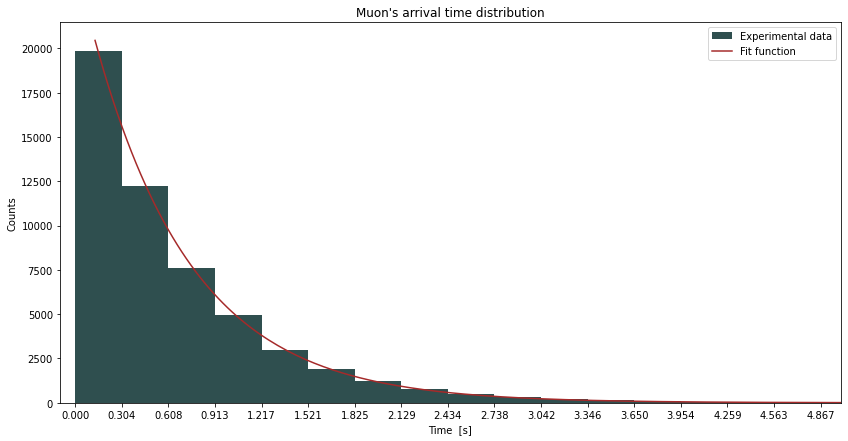

In [14]:
# fit
def exponential(x,A,gamma):
    return A*np.exp(-gamma*x)

hist_val, bin_edges = np.histogram(times_data.diff_time.dropna(), bins=25)
middle_edges = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]

par, cov = curve_fit(exponential, middle_edges, hist_val, p0=(1000,1e-9))

# print results
print('Fit function :')
display(Math(r'f(t) = A e^{-\lambda t}'))
display(Math(fr''))
print('Fit parameters :')
display(Math(fr'A = ({par[0]*1e-3:.1f} \pm {np.sqrt(cov[0,0])*1e-3:.1f}) \cdot 10^3 '))
display(Math(fr'\gamma = ({par[1]:.3f} \pm {np.sqrt(cov[1,1]):.3f} ) \quad Hz'))
print('Mean time between two muons :')
display(Math(fr'\Delta T = ({1/(par[1]):.3f} \pm {np.sqrt(cov[1,1])/(par[1]):.3f} ) \quad s'))

# plot results
x_plot = np.linspace(0.13,15,500)
y_plot = exponential(x_plot,*par)

plt.figure(figsize=(14,7))
plt.hist(times_data.diff_time, bins=25, color='darkslategray', label='Experimental data')
plt.plot(x_plot, y_plot, 'brown', label='Fit function')
plt.title("Muon's arrival time distribution")
plt.xlabel('Time  [s]')
plt.ylabel('Counts')
plt.xticks(ticks=bin_edges)
plt.xlim(-0.1,5)
plt.legend()
plt.show()

### Filter by hits per orbit

Dropping the entire orbit if the number of hits exceeds 15

In [15]:
data.createOrReplaceTempView("data_table")
data = spark.sql("SELECT * \
                    FROM (SELECT * FROM data_table WHERE ORBIT IN (SELECT DISTINCT ORBIT FROM data_table WHERE CHAMBER==4)) \
                    WHERE ORBIT IN (SELECT DISTINCT ORBIT \
                                    FROM (SELECT ORBIT, COUNT(*) AS COUNT \
                                           FROM data_table \
                                           GROUP BY (ORBIT) \
                                           HAVING count < 15))")
spark.catalog.dropTempView("data_table")

### Filter orbits with only one scintillator signal per orbit

In [16]:
data.createOrReplaceTempView("data_table")
data = spark.sql("SELECT * \
                  FROM data_table \
                  WHERE ORBIT IN (SELECT DISTINCT ORBIT \
                                  FROM (SELECT ORBIT, SUM(CASE WHEN CHAMBER = 4 THEN 1 ELSE 0 END) AS COUNT \
                                        FROM data_table \
                                        GROUP BY ORBIT \
                                        HAVING COUNT = 1))")
spark.catalog.dropTempView("data_table")

### Add $x_{hit}$ feature

In [17]:
data.createOrReplaceTempView("data_table")

# data2 contains only t0 information
data2 = spark.sql("SELECT * \
                   FROM data_table \
                   WHERE CHAMBER = 4")

data2.createOrReplaceTempView("data_table2")

Calculate the position inside the cell:

$$
x_{\text {hit }}=\left(t_{\text {hit }}-t_{0}\right) v_{\text {drift}} \quad with \quad v_{\text {drift }}=53.8 \frac{\mu m}{n s} 
$$

In [18]:
data = spark.sql("SELECT data_table.CHAMBER, data_table.CHAN, data_table.ORBIT, \
                  53.8*(data_table.T_HIT_ns - data_table2.T_HIT_ns) AS x_hit \
                  FROM data_table \
                  INNER JOIN data_table2 ON data_table.ORBIT = data_table2.ORBIT \
                  WHERE data_table.CHAMBER != 4")

In [19]:
spark.catalog.dropTempView("data_table")
spark.catalog.dropTempView("data_table2")

### Compute left-right position for each hit in the laboratory reference frame

In [20]:
data.createOrReplaceTempView("data_table")
data = spark.sql("SELECT CHAMBER, CHAN, ORBIT, \
              CASE \
                  WHEN (((CHAMBER = 0) OR (CHAMBER = 2)) AND ((CHAN%4 = 0) OR (CHAN%4 = 1))) THEN 42000*(CHAN DIV 4) + 21000 - x_hit \
                  WHEN (((CHAMBER = 0) OR (CHAMBER = 2)) AND ((CHAN%4 = 2) OR (CHAN%4 = 3))) THEN 42000*(CHAN DIV 4) + 42000 - x_hit \
                  WHEN (((CHAMBER = 1) OR (CHAMBER = 3)) AND ((CHAN%4 = 0) OR (CHAN%4 = 1))) THEN 42000*((CHAN-64) DIV 4) + 21000 - x_hit \
                  WHEN (((CHAMBER = 1) OR (CHAMBER = 3)) AND ((CHAN%4 = 2) OR (CHAN%4 = 3))) THEN 42000*((CHAN-64) DIV 4) + 42000 - x_hit \
              END AS x_L, \
              CASE \
                  WHEN (((CHAMBER = 0) OR (CHAMBER = 2)) AND ((CHAN%4 = 0) OR (CHAN%4 = 1))) THEN 42000*(CHAN DIV 4) + 21000 + x_hit \
                  WHEN (((CHAMBER = 0) OR (CHAMBER = 2)) AND ((CHAN%4 = 2) OR (CHAN%4 = 3))) THEN 42000*(CHAN DIV 4) + 42000 + x_hit \
                  WHEN (((CHAMBER = 1) OR (CHAMBER = 3)) AND ((CHAN%4 = 0) OR (CHAN%4 = 1))) THEN 42000*((CHAN-64) DIV 4) + 21000 + x_hit \
                  WHEN (((CHAMBER = 1) OR (CHAMBER = 3)) AND ((CHAN%4 = 2) OR (CHAN%4 = 3))) THEN 42000*((CHAN-64) DIV 4) + 42000 + x_hit \
              END AS x_R \
          FROM data_table")

In [21]:
spark.catalog.dropTempView("data_table")
data.createOrReplaceTempView("data_table")

data = spark.sql("SELECT CHAMBER, CHAN, ORBIT, x_L, x_R, \
                  CASE \
                      WHEN ((CHAMBER==0) AND (CHAN % 4 = 0)) THEN (219.8 + 19.5)* 1000 \
                      WHEN ((CHAMBER==0) AND (CHAN % 4 = 1)) THEN (219.8 - 6.5)* 1000 \
                      WHEN ((CHAMBER==0) AND (CHAN % 4 = 2)) THEN (219.8 + 6.5)* 1000 \
                      WHEN ((CHAMBER==0) AND (CHAN % 4 = 3)) THEN (219.8 - 19.5)* 1000 \
                      WHEN ((CHAMBER==1) AND (CHAN % 4 = 0)) THEN (977.3 + 19.5)* 1000 \
                      WHEN ((CHAMBER==1) AND (CHAN % 4 = 1)) THEN (977.3 - 6.5)* 1000 \
                      WHEN ((CHAMBER==1) AND (CHAN % 4 = 2)) THEN (977.3 + 6.5)* 1000 \
                      WHEN ((CHAMBER==1) AND (CHAN % 4 = 3)) THEN (977.3 - 19.5)* 1000 \
                      WHEN ((CHAMBER==2) AND (CHAN % 4 = 0)) THEN (1035.6 + 19.5)* 1000 \
                      WHEN ((CHAMBER==2) AND (CHAN % 4 = 1)) THEN (1035.6 - 6.5)* 1000 \
                      WHEN ((CHAMBER==2) AND (CHAN % 4 = 2)) THEN (1035.6 + 6.5)* 1000 \
                      WHEN ((CHAMBER==2) AND (CHAN % 4 = 3)) THEN (1035.6 - 19.5)* 1000 \
                      WHEN ((CHAMBER==3) AND (CHAN % 4 = 0)) THEN (1819.8 + 19.5)* 1000 \
                      WHEN ((CHAMBER==3) AND (CHAN % 4 = 1)) THEN (1819.8 - 6.5)* 1000 \
                      WHEN ((CHAMBER==3) AND (CHAN % 4 = 2)) THEN (1819.8 + 6.5)* 1000 \
                      WHEN ((CHAMBER==3) AND (CHAN % 4 = 3)) THEN (1819.8 - 19.5)* 1000 \
                  END AS z \
              FROM data_table")

# Track reconstruction

### Local track

In [22]:
def best_fit(x):
    comb_RL = list(itertools.product(*[[a,b] for a,b in zip(x[0],x[1])]))  # computing all left-right combinations

    comb_fit = []
    for i in range(len(comb_RL)):                                          # performing the fit over the combinations
        p, res, _,_,_ = np.polyfit(comb_RL[i], x[2], 1, full=True)
        comb_fit.append([list(res)+list(p), list(comb_RL[i])])    
    
    idxmin = np.argmin(np.array([el[0][0] for el in comb_fit]))            # save the best fit using residuals
    return [comb_fit[idxmin][0][1:], comb_fit[idxmin][1], x[2]]

After reshaping the data to a Spark paired RDD, we decided to use a combineByKey instead a reduceByKey to efficiently redefine the schema again. In this way we properly prepare each record in order to perform the calculation of all possible combinations of hits, and therefore all the local linear regressions for fixed chamber and orbit.

The filter is used to eliminate orbits with less than two hits in order to be able to perform a meaningful linear fit. In fact when we have only two points we are not able to figure out which linear regression line is best (both will be perfect), and therefore resolve the left and right ambiguity.

In [23]:
rdd = data.rdd.map(lambda x: ((x[0], x[2]), [x[3], x[4], float(x[5])])) \
              .combineByKey((lambda x: [[x[0]], [x[1]], [x[2]]]), \
                         (lambda x,y: [x[0]+[y[0]], x[1]+[y[1]], x[2]+[y[2]]]), \
                         (lambda x,y: [x[0]+y[0], x[1]+y[1], x[2]+y[2]])) \
              .filter(lambda x: len(x[1][0]) > 2) \
              .mapValues(lambda x: best_fit(x))

The RDD created is structured as a list of items (key, value), where: 
- key = (CHAMBER, ORBIT)
- value = [[angular coefficient, intercept], [combination of x], [z corresponding to the x combination]] 

In [24]:
rdd.take(1)

[((1, 40159482),
  [[3.7727509886870667, -1008088.1172158099],
   [524028.02734375, 531934.841015625, 521829.341015625, 527184.3694335937],
   [970800.0, 996800.0, 957800.0, 983800.0]])]

### Global track

Using the results from the local-track reconstruction we can eliminate the left and right ambiguity by taking only the combination of hits corrisponding to the best fit for each orbit and chamber. 
So then using this set of data the global-track reconstruction is performed using a least-squares fit only of chambers zero, two and three (the ones measuring the same view), all the records about the chamber one are initially dropped.

Each record contained in the resulting paired RDD, that is rdd_global, is structured as following:
- a key containing the orbit information: (ORBIT)
- a nested list value made of the regression coefficients [angular coefficient, intercept] and all the x and z hit combinations from all the chamber at fixed orbit: [[angular coefficient, intercept], [all x combinations],[all z corresponding to the x combinations]]

In [25]:
# function to reshape data format
def recast(x):
    X, Z = [], []
    for i in x:
        X+=i[0]
        Z+=i[1]
    return [X,Z]

In [26]:
rdd_global = data.rdd \
                 .filter(lambda x: x[0]!=1) \
                 .map(lambda x: ((x[0], x[2]), [x[3], x[4], float(x[5])])) \
                 .combineByKey((lambda x: [[x[0]], [x[1]], [x[2]]]), \
                               (lambda x,y: [x[0]+[y[0]], x[1]+[y[1]], x[2]+[y[2]]]), \
                               (lambda x,y: [x[0]+y[0], x[1]+y[1], x[2]+y[2]])) \
                 .mapValues(lambda x: best_fit(x)) \
                 .map(lambda x: (x[0][1], [x[1][1], x[1][2]])) \
                 .reduceByKey(lambda x, y: recast([x,y])) \
                 .filter(lambda x: len(x[1][0]) > 2) \
                 .mapValues(lambda x: [list(np.polyfit(x[0], x[1], 1)), x[0], x[1]])

# PLOT

### Local track

In [27]:
# custom plot function
def plot_local(x, m, b):
    plt.figure(figsize=(15, 10))
    plt.scatter(x[0], x[2])                 
    plt.scatter(x[1], x[2]) 
    
    Xmin = int(min(x[0]+x[1]))
    Xmax = int(max(x[0]+x[1]))
    X = np.arange(Xmin, Xmax)
    plt.plot(X, m*X+b, '-')
    plt.title('Local linear regression')
    plt.xlabel('X  [µm]')
    plt.ylabel('Z  [µm]')
    plt.grid()
    plt.show()

In [28]:
Orb = 5315874
Ch = 2

# this rdd contains the hits position for a specific Orbit and Chamber
x_local = data.rdd \
          .filter(lambda x: (x[0]==Ch)&(x[2]==Orb)) \
          .map(lambda x: ((x[0], x[2]), [x[3], x[4], float(x[5])])) \
          .combineByKey((lambda x: [[x[0]], [x[1]], [x[2]]]), \
                     (lambda x,y: [x[0]+[y[0]], x[1]+[y[1]], x[2]+[y[2]]]), \
                     (lambda x,y: [x[0]+y[0], x[1]+y[1], x[2]+y[2]])) \
          .collect()[0][1]

In [29]:
# this rdd contains the parameters of the fit obtained for a specific Orbit and Chamber
coeff_local = data.rdd \
            .filter(lambda x: (x[0]==Ch)&(x[2]==Orb)) \
            .map(lambda x: ((x[0], x[2]), [x[3], x[4], float(x[5])])) \
            .combineByKey((lambda x: [[x[0]], [x[1]], [x[2]]]), \
                     (lambda x,y: [x[0]+[y[0]], x[1]+[y[1]], x[2]+[y[2]]]), \
                     (lambda x,y: [x[0]+y[0], x[1]+y[1], x[2]+y[2]])) \
            .mapValues(lambda x: best_fit(x)) \
            .collect()[0][1][0]

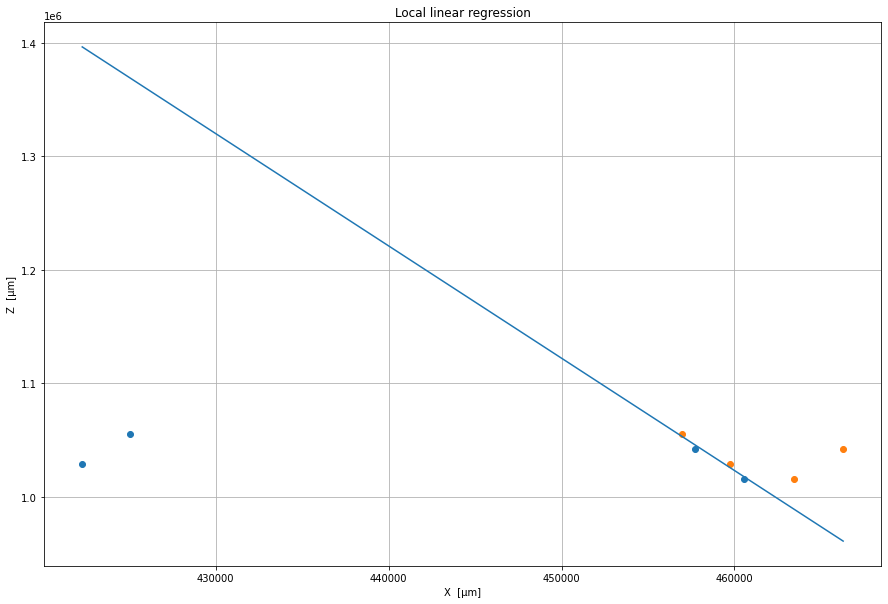

In [30]:
plot_local(x_local, coeff_local[0], coeff_local[1])

### Global track

In [31]:
def plot_global(x, m, b):
    plt.figure(figsize=(15, 10))
    plt.scatter(x[0], x[1])                 
    
    Xmin = int(min(x[0]))
    Xmax = int(max(x[0]))
    X = range(Xmin, Xmax)
    plt.plot(X, m*X+b, '-')
    plt.title('Global linear regression')
    plt.xlabel('X  [µm]')
    plt.ylabel('Z  [µm]')
    plt.axhline(245800, linestyle='--', label='Chamber borders')
    plt.axhline(193800, linestyle='--')
    #plt.axhline(1003.3, linestyle='--')
    #plt.axhline(951.3, linestyle='--')
    plt.axhline(1061600, linestyle='--')
    plt.axhline(1009600, linestyle='--')
    plt.axhline(1845600, linestyle='--')
    plt.axhline(1793600, linestyle='--')
    plt.legend(prop={'size': 12})
    plt.grid()
    plt.show()

In [32]:
# this rdd is structures as :  [ [fit coefficients], [x], [z] ] for a specific Orbit and Chamber
global_plot_data = data.rdd \
        .filter(lambda x: ((x[2]==Orb)&(x[0]!=1))) \
        .map(lambda x: ((x[0], x[2]), [x[3], x[4], float(x[5])])) \
        .combineByKey((lambda x: [[x[0]], [x[1]], [x[2]]]), \
                     (lambda x,y: [x[0]+[y[0]], x[1]+[y[1]], x[2]+[y[2]]]), \
                     (lambda x,y: [x[0]+y[0], x[1]+y[1], x[2]+y[2]])) \
        .mapValues(lambda x: best_fit(x)) \
        .map(lambda x: (x[0][1], [x[1][1], x[1][2]])) \
        .reduceByKey(lambda x, y: recast([x,y])) \
        .mapValues(lambda x: [list(np.polyfit(x[0], x[1], 1)), x[0], x[1]]) \
        .collect()[0][1]

x_global = [global_plot_data[1], global_plot_data[2]]
coeff_global = [global_plot_data[0][0], global_plot_data[0][1]]

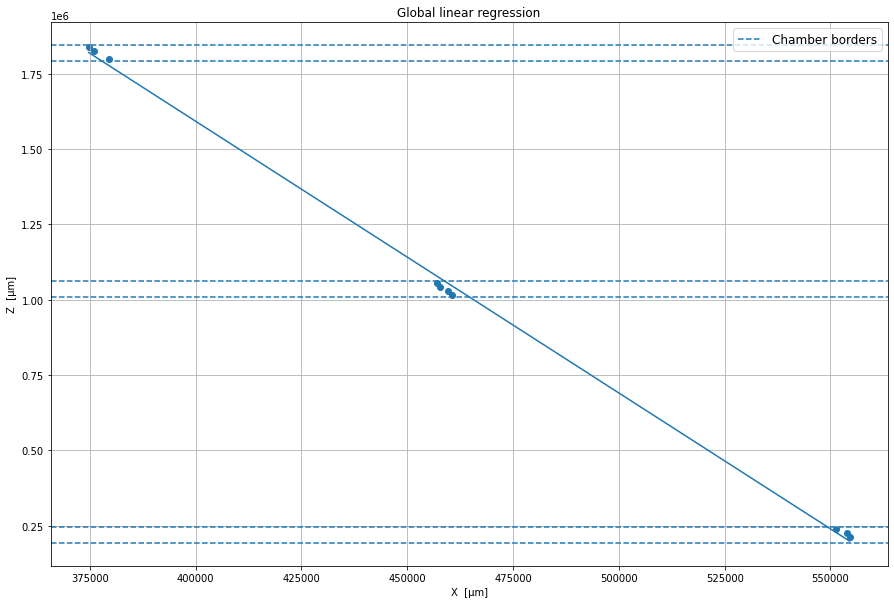

In [33]:
plot_global(x_global, coeff_global[0], coeff_global[1])

# Angular resolution

For the estimation of the detector angular resolution the angle between the global track and the local track
measured from Chamber 2 is calculated.

In [34]:
schema_global = StructType(
    [
        StructField('ORBIT', IntegerType(), False),
        StructField('m_g', DoubleType(), True),
    ]
)
data_global = rdd_global.map(lambda x: [x[0]]+[float(x[1][0][0])]).toDF(schema_global)

schema_local = StructType(
    [
        StructField('CHAMBER', IntegerType(), True),
        StructField('ORBIT', IntegerType(), False),
        StructField('m_l', DoubleType(), True),
    ]
)
data_local = rdd.map(lambda x: [x[0][0],x[0][1]]+[float(x[1][0][0])]).toDF(schema_local)

In [35]:
ang_res = data_local[data_local['CHAMBER']==2]  \
                    .join(data_global, "ORBIT") \
                    .withColumn("theta", atan((col('m_g') - col('m_l'))/(1 + col('m_g')*col('m_l'))))
ang_res.show()

+---------+-------+--------------------+--------------------+--------------------+
|    ORBIT|CHAMBER|                 m_l|                 m_g|               theta|
+---------+-------+--------------------+--------------------+--------------------+
|277147041|      2|   2.389896046996535|  2.4079759928655693|0.002676595865648...|
| 59639782|      2| -11.145448292833795|  -11.53043661780416|-0.00297260124547...|
|306185377|      2|  3.3141165768822147|  3.1755905064653254|-0.01201979069765...|
| 84911847|      2| -0.5195868129567242|   5.751334896079253| -1.2637539652393888|
|367839514|      2|   4.489467777419491|  3.5477692818473052|-0.05557368246776899|
|300103653|      2|0.005060852206941...|-0.03080280016708...|-0.03585387268312...|
|356488776|      2| -0.5804321434688327| -0.5804321434688327|                 0.0|
|166104390|      2|  3.1109873307407567|   5.029124187730483|  0.1147282339122782|
|162988622|      2|  -0.790215041241543|  11.633277705092125| -0.9877998713468277|
|378

In [36]:
theta = ang_res.select('theta').rdd.flatMap(lambda x: x).collect()  

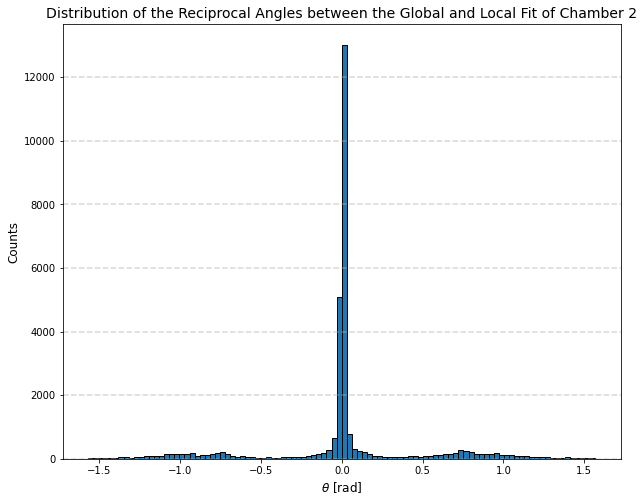

In [37]:
plt.figure(figsize=(10, 8))
plt.hist(theta, bins=100, edgecolor='k') 
plt.grid(axis = 'y', linestyle = '--', linewidth = 1.5, alpha = 0.5)
plt.title('Distribution of the Reciprocal Angles between the Global and Local Fit of Chamber 2', fontsize = 14)
plt.xlabel('$\\theta$ [rad]', fontsize = 12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

# Comparing the local and global track reconstruction

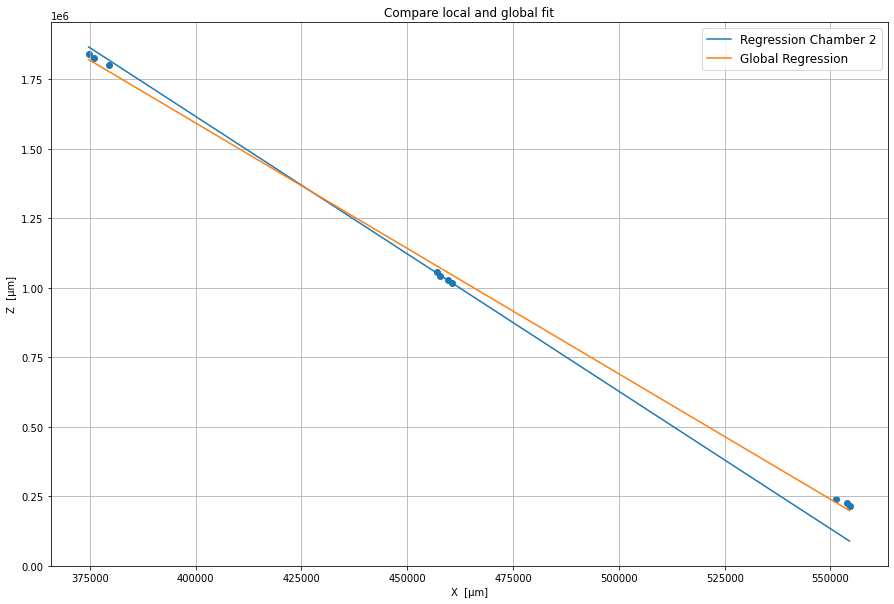

In [38]:
def total_plot(Glob, m_loc, b_loc, m_glob, b_glob):
    plt.figure(figsize=(15, 10))
    plt.scatter(Glob[0], Glob[1])                 
    
    Gmin = int(min(Glob[0]))
    Gmax = int(max(Glob[0]))
    X = np.arange(Gmin, Gmax)
    plt.plot(X, m_loc*X+b_loc, '-', label='Regression Chamber 2')
    plt.plot(X, m_glob*X+b_glob, '-', label='Global Regression')
    plt.legend(prop={'size': 12})
    plt.title('Compare local and global fit')
    plt.xlabel('X  [µm]')
    plt.ylabel('Z  [µm]')
    plt.grid()
    plt.show()
    
total_plot(x_global, coeff_local[0], coeff_local[1], coeff_global[0], coeff_global[1])

# Appendix

### Computing the distribution of the muons' arrival time in parallel

In the next cell it is reported the code which aim to obtain the results found in Chapter .

Fit parameters :


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Mean time between two muons :


<IPython.core.display.Math object>

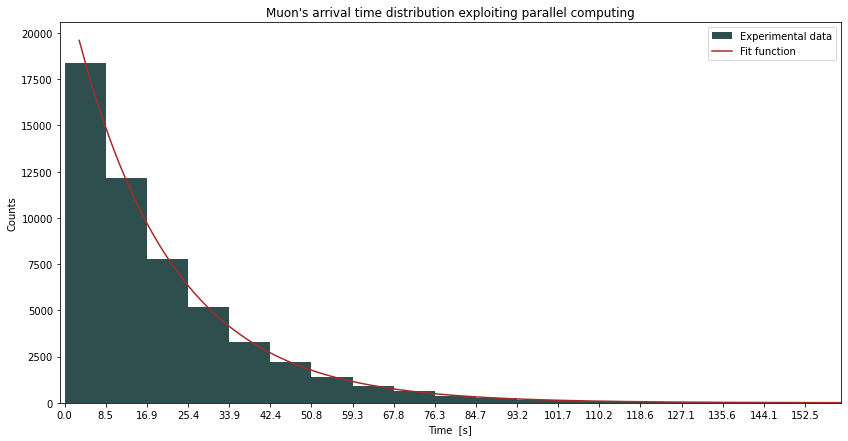

In [39]:
# manipulate the dataframe
b = data_appendix
b = b.filter(b.CHAMBER==4).select(col("T_HIT_ns"), col('TDC'))
w = Window.partitionBy('TDC').orderBy('T_HIT_ns')
# create a column with shifted data
c = b.withColumn('lead', f.lag('T_HIT_ns', 1).over(w)) \
     .withColumn('t0_diff', f.when(f.col('lead').isNotNull(), f.col('T_HIT_ns') - f.col('lead')).otherwise(f.lit(None))) \
     .withColumn('t0_diff', col('t0_diff')*1e-9)              # compute the between-muons' time and convert in seconds
d = c.select("t0_diff").toPandas()                            # move datat to a Pandas dataframe

# executing the fit
hist_val, bin_edges = np.histogram(d.t0_diff.dropna(), bins=25)#, density=True)
middle_edges = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
def exponential(x,A,gamma):
    return A*np.exp(-gamma*x)
par, cov = curve_fit(exponential, middle_edges, hist_val, p0=(25000,1.5e-9), method='lm')

# print results
print('Fit parameters :')
display(Math(fr'A = ({par[0]*1e-3:.1f} \pm {np.sqrt(cov[0,0])*1e-3:.1f}) \cdot 10^3 '))
display(Math(fr'\gamma = ({par[1]:.4f} \pm {np.sqrt(cov[1,1]):.4f} ) \quad Hz'))
print('Mean time between two muons :')
display(Math(fr'\Delta T = ({1/(par[1]):.3f} \pm {np.sqrt(cov[1,1])/(par[1]):.3f} ) \quad s'))

# plot results
plt.figure(figsize=(14,7))
x_plot = np.linspace(3,200,500)
y_plot = exponential(x_plot,*par)
plt.hist(d.t0_diff, bins=25, color='darkslategray', label='Experimental data')
plt.plot(x_plot, y_plot, 'brown', label='Fit function')
plt.title("Muon's arrival time distribution exploiting parallel computing")
plt.xlabel('Time  [s]')
plt.ylabel('Counts')
plt.xticks(ticks=bin_edges)
plt.xlim(-1,160)
plt.legend()
plt.show()

We can note that the histogram and the $\gamma$ parameter obtained are sensibly different from the ones obtained executing the computation only on the master resources. This is caused by the line "w = Window.partitionBy('TDC').orderBy('T_HIT_ns')", where we impose a data partiton based on the TDC channel. Consequently, when sorting arrival times and computing the difference between them, the difference are not computed between consequent muons (because their information stands in different partitions) and this results in greater between-muons arrival time, which causes the histogram to be scaled in the x-axis.

Note that executing the partition on a different column, like FPGA, CHAN or CHAMBER will results in allocate all data informations on a single partition. Providing no column to the partitionBy() function also causes Spark to save every record in a single virtual machine, thus losing all the advantages of exploiting a computing cluster.

# STOP

In [41]:
sc.stop()
spark.stop()

# Comment on the usage of persist

We try to use a persist in different points of the code in order to speed up the execution. In perticular, we place it:
- after the unpacking of data
- after time corrections
- before track reconstruction

We note that in the first two cases the job fails. This could be due to the fact that at the beginning
data size is very large, while in the third circumstance, and so after the initial processing, it is smaller. We try setting different pyspark.StorageLevel configurations: memory only, disk only, memory and disk all leading to the same result. 
In the third case, the job is completed succesfully even though some executors die and some tasks fail. 
Without using persist, all executors work properly during the whole run and we achive a slight improvement in the execution time.